/tmp/ipykernel_58751/3238340671.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))


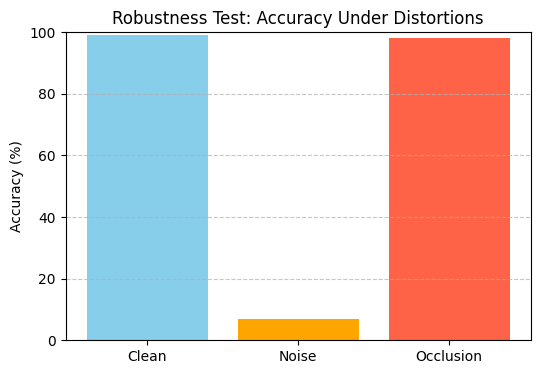

In [1]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = '/root/Aerial_Landscapes'
MODEL_PATH = './efficientnet_b0.pth'
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 15

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = ImageFolder(DATA_DIR, transform=transform)
class_names = dataset.classes
val_size = int(0.2 * len(dataset))
_, val_dataset = torch.utils.data.random_split(dataset, [len(dataset) - val_size, val_size])
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = efficientnet_b0(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

def add_noise(image_tensor, noise_level=0.1):
    noise = torch.randn_like(image_tensor) * noise_level
    return torch.clamp(image_tensor + noise, 0., 1.)

def add_occlusion(image_tensor, size=40):
    img = image_tensor.clone()
    c, h, w = img.shape
    x = np.random.randint(0, w - size)
    y = np.random.randint(0, h - size)
    img[:, y:y+size, x:x+size] = 0.0
    return img

def evaluate(model, loader, transform_fn=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            if transform_fn:
                images = torch.stack([transform_fn(img) for img in images])
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return 100. * correct / total

acc_clean = evaluate(model, val_loader)
acc_noise = evaluate(model, val_loader, transform_fn=add_noise)
acc_occ = evaluate(model, val_loader, transform_fn=add_occlusion)

labels = ['Clean', 'Noise', 'Occlusion']
values = [acc_clean, acc_noise, acc_occ]

plt.figure(figsize=(6,4))
plt.bar(labels, values, color=['skyblue', 'orange', 'tomato'])
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Robustness Test: Accuracy Under Distortions')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()
